# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**Описание данных**

Данные находятся в файле `/datasets/autos.csv`.

**Признаки**
* *DateCrawled* — дата скачивания анкеты из базы
* *VehicleType* — тип автомобильного кузова
* *RegistrationYear* — год регистрации автомобиля
* *Gearbox* — тип коробки передач
* *Power* — мощность (л. с.)
* *Model* — модель автомобиля
* *Kilometer* — пробег (км)
* *RegistrationMonth* — месяц регистрации автомобиля
* *FuelType* — тип топлива
* *Brand* — марка автомобиля
* *Repaired* — была машина в ремонте или нет
* *DateCreated* — дата создания анкеты
* *NumberOfPictures* — количество фотографий автомобиля
* *PostalCode* — почтовый индекс владельца анкеты (пользователя)
* *LastSeen* — дата последней активности пользователя

**Целевой признак**

*Price* — цена (евро)

**Этапы работы:**

1. Загрузить данные.
2. Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
3. Подготовить выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.



## Подготовка данных

### Загрузка и изучение данных

Импортируем библиотеки и модули, которые потребуются для выполнения проекта

In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Загрузим и изучим данные

In [2]:
try:
    data = pd.read_csv('datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Для знакомства с данными выведем первые 5 строк датасета, информацию о данных и описательную статистику для количественных данных.

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете всего 16 столбцов и 354369 строк, формат данных – `object` (категориальные данные) или `int`(целочисленный). В данных присутствуют пропуски. Переведем значения столбцов  `'DateCrawled'`, `'DateCreated'`, `'LastSeen'` в формат `datetime`.

In [6]:
data[['DateCrawled', 'DateCreated', 'LastSeen']] = data[['DateCrawled', 
                                                       'DateCreated', 
                                                       'LastSeen']].apply(pd.to_datetime)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описательная статистика показывает проблемы с данными. Например, минимальная цена - 0, минимальная мощность – 0, максимальная мощность – 20000, самый ранний год регистрации – 1000, самый поздний - 9999, есть нулевые значения в столбце `'Month'`, в столбце `'NumberOfPictures'` присутствуют только нулевые значения (что делает его бесполезным). 

Далее проведем **предобработку** данных. Для этого:
   *  удалим дубликаты;
   * обработаем выбросы и аномалии;
   * обработаем аномалии;
   * удалим неинформатиные столбцы.

### Предобработка данных

#### Устранение дубликатов

Посмотрим, есть ли полные дубликаты

In [9]:
data.duplicated().sum()

4

Всего 4 дубликата. Удалим их.

In [10]:
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

Дубликаты удалены.

#### Обработка выбросов и аномальных значений

Выше было отмечено, что данные содержат неправдоподобные значения. Рассмотрим распределение значений в столбцах и удалим аномалии. Будем рассматривать аномальные значения только в тех столбцах, которые потребуются для обучения (остальные столбцы удалим в конце подготовки данных).

**Столбец `'Price'`**

<AxesSubplot:>

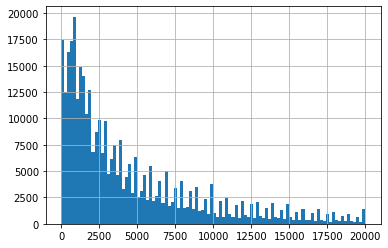

In [12]:
data['Price'].hist(bins=100)

В столбце `'Price'` присутствуют нулевые значения. Чтобы избавиться от аномальных значений цены, отсечем 1% наиболее низких значений.

In [13]:
np.percentile(data['Price'], 1)

0.0

In [14]:
data = data.query('0 < Price')

Дальше увеличивать минимальный порог цены не будем. Можно было бы взять пороговое значение в 100, 300 или 500 евро, но это значение будет произвольным, в то время как мы не знаем обстоятельств и условий продажи: возможно, автомобиль продается на запчасти или утилизацию. При этом на гистограмме нет явных отклонений.

**Столбец `'VehicleType'`**

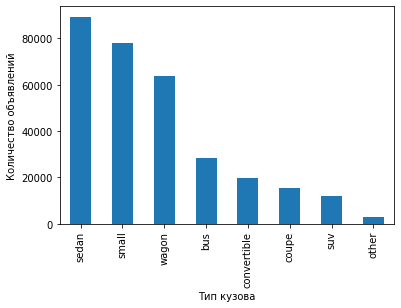

In [15]:
data['VehicleType'].value_counts().plot(kind='bar', xlabel='Тип кузова', ylabel='Количество объявлений');

Седан – наиболее распространенный тип кузова в мире (https://www.autoopt.ru/articles/products/3225024), что согласуется с данными рассматриваемой базы объявлений.

**Столбец `'RegistrationYear'`**

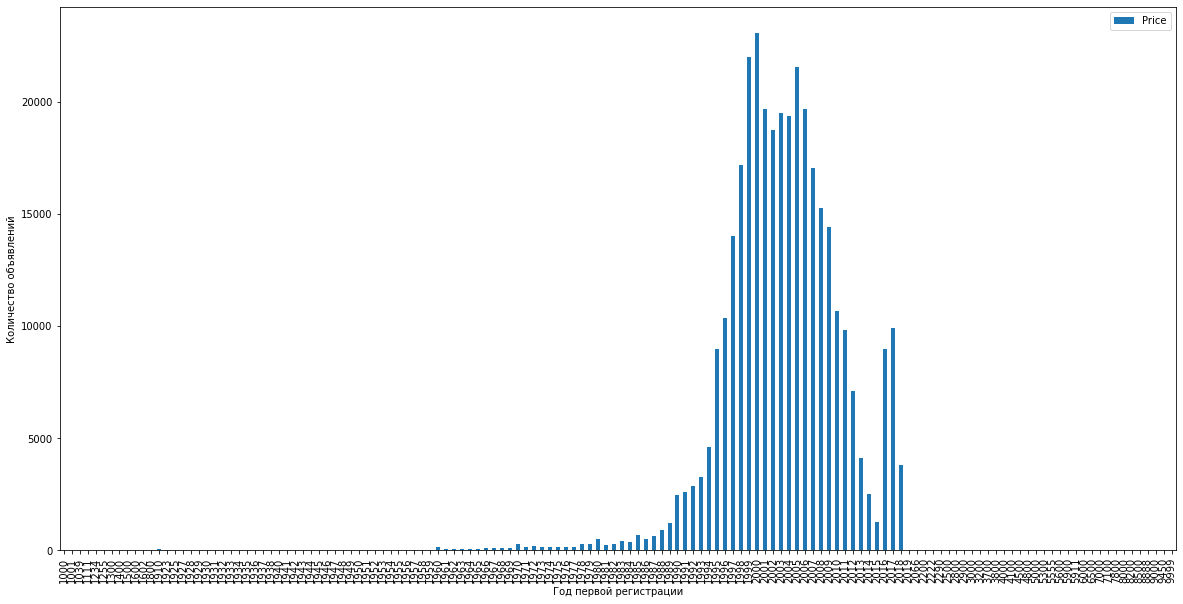

In [16]:
data.pivot_table(index='RegistrationYear',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                figsize=(20, 10),
                                                xlabel='Год первой регистрации',
                                                ylabel='Количество объявлений')
plt.show()

Минимальный адекватный год регистрации – 1960. Таких объявлений немного, но попадание в базу объявлений старых и раритетных автомобилей с таким годом регистрации не кажется нереалистичным. 

In [17]:
data = data.query('1960 <= RegistrationYear')

Максимальное значение года регистрации не должно быть позже даты создания объявления. 

In [18]:
display(data['DateCreated'].min())
data['DateCreated'].max()

Timestamp('2014-03-10 00:00:00')

Timestamp('2016-04-07 00:00:00')

Обьявления созданы в период с марта 2014 года по апрель 2016 года. Добавим в датасет столбцы 'MonthCreated' и 'YearCreated'. Год регистрации не может быть позже года создания объявления. Если год регистрации и год создания объявления совпадают, месяц регистрации не может быть больше месяца создания объявления.

In [19]:
data['YearCreated'] = data['DateCreated'].dt.year
data['MonthCreated'] = data['DateCreated'].dt.month

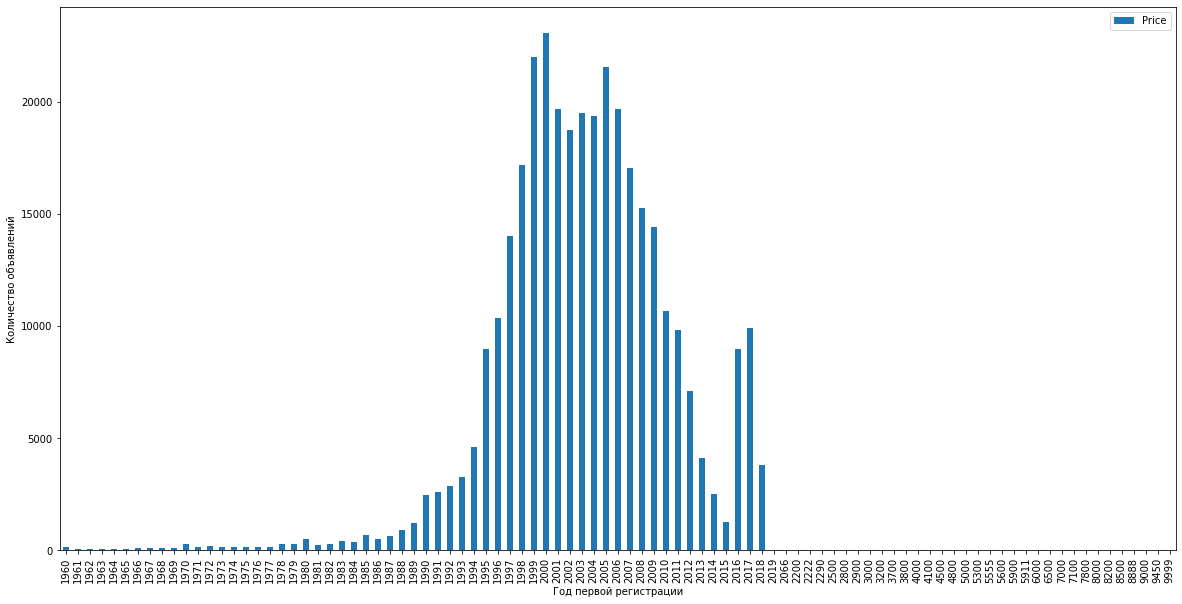

In [20]:
data.pivot_table(index='RegistrationYear',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                figsize=(20, 10),
                                                xlabel='Год первой регистрации',
                                                ylabel='Количество объявлений')
plt.show()

In [21]:
data = data[(data['RegistrationYear'] < data['YearCreated']) |
                  ((data['RegistrationYear'] == data['YearCreated']) &
                  (data['MonthCreated'] > data['RegistrationMonth']))]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323856 entries, 0 to 354364
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        323856 non-null  datetime64[ns]
 1   Price              323856 non-null  int64         
 2   VehicleType        309487 non-null  object        
 3   RegistrationYear   323856 non-null  int64         
 4   Gearbox            308834 non-null  object        
 5   Power              323856 non-null  int64         
 6   Model              309036 non-null  object        
 7   Kilometer          323856 non-null  int64         
 8   RegistrationMonth  323856 non-null  int64         
 9   FuelType           301943 non-null  object        
 10  Brand              323856 non-null  object        
 11  Repaired           266393 non-null  object        
 12  DateCreated        323856 non-null  datetime64[ns]
 13  NumberOfPictures   323856 non-null  int64   

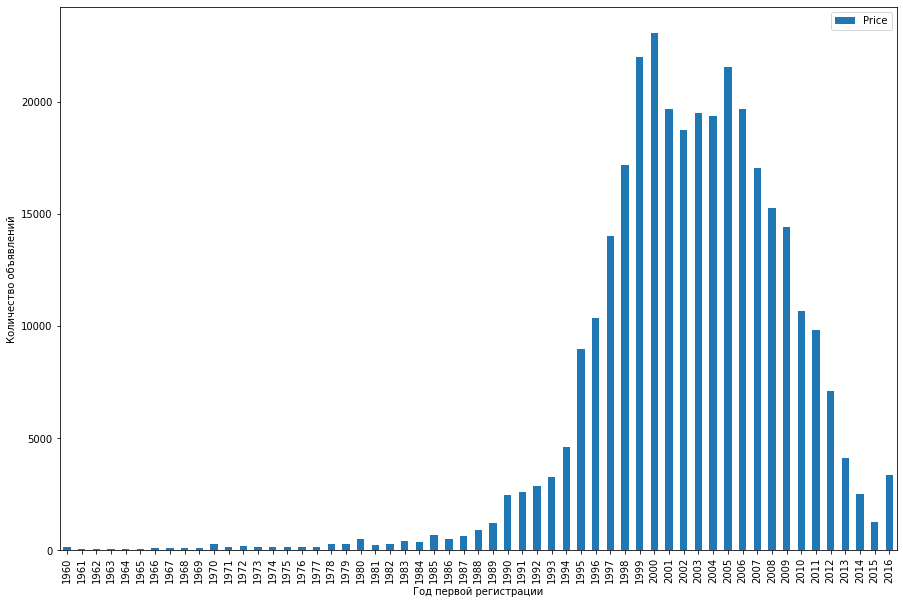

In [23]:
data.pivot_table(index='RegistrationYear',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                figsize=(15, 10),
                                                xlabel='Год первой регистрации',
                                                ylabel='Количество объявлений')
plt.show()

**Столбец `'Gearbox'`**

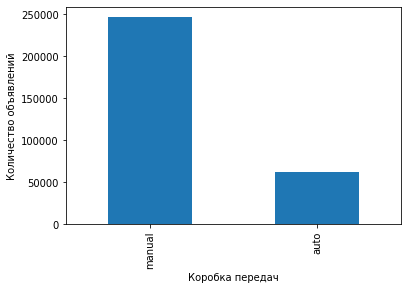

In [24]:
data['Gearbox'].value_counts().plot(kind='bar', xlabel='Коробка передач', ylabel='Количество объявлений');

Количество автомобилей с механической коробкой передач значительно выше, чем с автоматической. Учитывая, что речь идет о подержанных автомобилях, зарегистрированных с 1960 года, данные выглядят правдоподобно. 

**Столбец `'Power'`**

В столбце `'Power'` присутствуют некорректные значения.

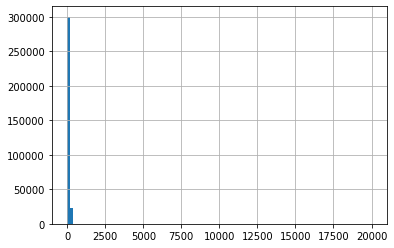

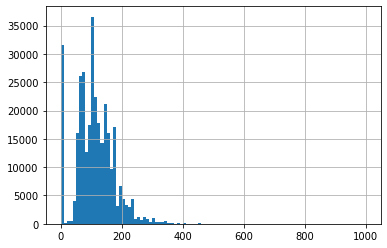

In [25]:
data['Power'].hist(bins=100)
plt.show()

data[(data['Power']<1000)]['Power'].hist(bins=100)
plt.show()

Мощность не может быть нулевой (однако автомобили с очень низкой мощностью существуют: https://automdb.com/min_power). Нулевых значений много, будем считать это ошибкой и удалим соответствующие строки. Также гистограммы показывают, что значения выше 400 л.с. также могут считаться выбросами.

In [26]:
data = data.query('1 <= Power <= 400')

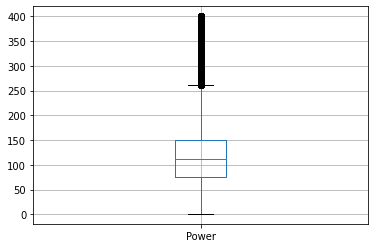

In [27]:
data.boxplot('Power');

**Столбец `'Kilometer'`**

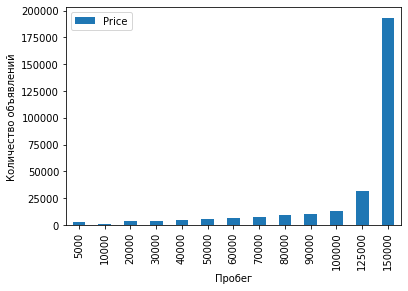

In [28]:
data.pivot_table(index='Kilometer',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                xlabel='Пробег',
                                                ylabel='Количество объявлений');

Больше всего автомобилей с пробегом 150000 км. Удивительно, что нет объявлений, превышающих данное значение. 

**Столбец `'FuelType'`**

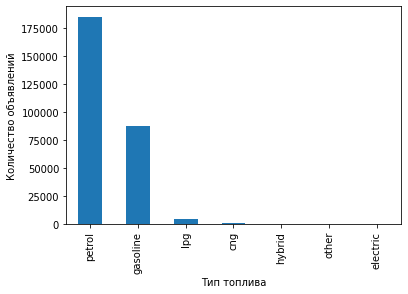

In [29]:
data['FuelType'].value_counts().plot(kind='bar', xlabel='Тип топлива', ylabel='Количество объявлений');

Больше всего автомобилей с типами топлива 'petrol' и 'gasoline'. Интересно, что оба обозначают бензин: 'gasoline' - североамериканский вариант английского языка, 'petrol' - международный вариант (https://en.wikipedia.org/wiki/Gasoline). Объединим эти варианты под названием 'petrol' как более распространенного.

In [30]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

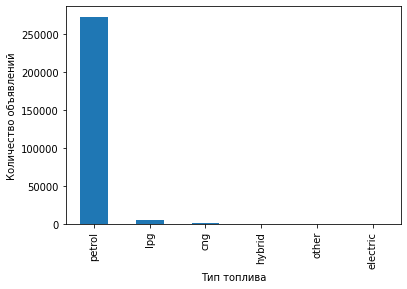

In [31]:
data['FuelType'].value_counts().plot(kind='bar', xlabel='Тип топлива', ylabel='Количество объявлений');

**Столбец `'Brand'`**

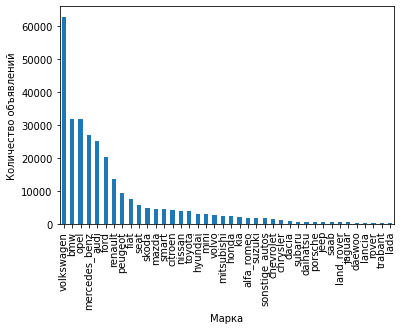

In [32]:
data['Brand'].value_counts().plot(kind='bar', xlabel='Марка', ylabel='Количество объявлений');

Больше всего автомобилей марки "Volkswagen". Это согласуется, например, с историческими данными о продажах автомобилей в Европе, где "Volkswagen Golf" почти каждый год занимает первое место по продажам (https://clck.ru/FgQEq)

Значения остальных столбцов либо нерелевантны, либо не подлежат обработке на предмет аномалий.

#### Обработка пропусков

Определим доли пропусков в разных столбцах.

In [33]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.023460
RegistrationYear     0.000000
Gearbox              0.017627
Power                0.000000
Model                0.036386
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.047039
Brand                0.000000
Repaired             0.141255
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
YearCreated          0.000000
MonthCreated         0.000000
dtype: float64

Пять столбцов содержат пропуски: `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'`, `'Repaired'`.

Доли пропусков в столбцах `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'` невелики. Их можно безболезненно удалить.

In [34]:
data = data.dropna(subset=['VehicleType', 
                           'Gearbox', 
                           'Model', 
                           'FuelType'])

Пропуски в столбце `'Repaired'` заменим на `'unknown'`.

In [35]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [36]:
data.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
YearCreated          0.0
MonthCreated         0.0
dtype: float64

Пропуски устранены.

### Удаление лишних столбцов

Данные в столбцах `'DateCreated'`, `'DateCrawled'`, `'LastSeen'` отображают дату создания анкеты, дату скачивания анкеты из базы и дату последней активности пользователя. Столбец `'PostalCode'` показывает почтовый индекс пользователя. Эти данные не являются признаками и не потребуются при обучении. Также сложно придумать, как месяц первой регистрации (`'RegistrationMonth'`) может влиять на стоимость подержанного автомобиля. В столбце `'NumberOfPictures'` присутствуют только нулевые значения, это делает его неинформативным. Столбцы `'MonthCreated'` и `'YearCreated'` были добавлены для текущих задач и также нерелевантны для обучения. Удалим указанные столбцы.

In [37]:
data_relevant = data[['Price',
                      'VehicleType', 
                      'RegistrationYear',
                      'Gearbox', 
                      'Power',
                      'Model',
                      'Kilometer',
                      'FuelType',
                      'Brand',
                      'Repaired']]

In [38]:
data_relevant = data_relevant.reset_index(drop=True)
data_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263166 entries, 0 to 263165
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             263166 non-null  int64 
 1   VehicleType       263166 non-null  object
 2   RegistrationYear  263166 non-null  int64 
 3   Gearbox           263166 non-null  object
 4   Power             263166 non-null  int64 
 5   Model             263166 non-null  object
 6   Kilometer         263166 non-null  int64 
 7   FuelType          263166 non-null  object
 8   Brand             263166 non-null  object
 9   Repaired          263166 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.1+ MB


**Выводы по шагу 1**

* Данные загружены и изучены.
* Обработаны аномальные значения и выбросы в столбцах `'Price'`, `'RegistrationYear'`, `'Power'`, `'FuelType'`. 
* Обработаны пропуски в столбцах `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'`, `'Repaired'`.
* Определены релевантные для обучения признаки.

## Обучение  и анализ моделей

Ниже проанилизаруем показатели следующих моделей:

* Дерево решений (DecisionTreeRegressor)
* Случайный лес (RandomForestRegressor)
* CatBoostRerressor
* LGBMRegressor
* Линейная регрессия (LinearRegression)

При выборе модели нас интересуют следующие параметры: 
* качество предсказания (используемая метрика – RMSE);
* время обучения модели;
* время предсказания модели.

Модель с наилучшими параметрами следует проверить на тестовой выборке

Определим значения интересующих нас параметров на кросс-валидации. При помощи `GridSearchCV` можно определить гипермараметры лучшей модели, лучшее значение метрики, среднее время обучения и предсказания модели);

### Подготовка выборок

#### Разделение на выборки

Разделим данные на признаки и целевой признак.

In [39]:
target = data_relevant['Price']
features = data_relevant.drop('Price', axis=1)

Разделим данные на обучающую и тестовую выборки в соотношении 3:1.

In [40]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [41]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
target_test.shape

(197374, 9)

(197374,)

(65792, 9)

(65792,)

Для экономии памяти удалим переменные `data`, `features` и `target` которая нам далее не потребуется.

In [42]:
del data

In [43]:
del features
del target

#### Преобразование признаков

Признаки в столбцах `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'`, `'Brand'`, `'Repaired'` – категориальные.
Преобразуем данные при помощи техники прямого кодирования (`One-Hot Encoding`) и порядкового кодирования (`OrdinalEncoder()`). Первое лучше подходит для линейных моделей, второе – для деревьев и бустингов.

##### Порядковое кодирование

In [44]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
oe_features_train = features_train.copy()
oe_features_test = features_test.copy()
oe_features_train[categorical] = encoder.fit_transform(features_train[categorical])
oe_features_test[categorical] = encoder.transform(features_test[categorical])

In [45]:
display(oe_features_train.shape)
oe_features_test.shape

(197374, 9)

(65792, 9)

In [46]:
display(oe_features_train.head())
oe_features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
169921,0.0,2005,1.0,145,14.0,150000,5.0,19.0,0.0
90884,4.0,2011,0.0,90,26.0,60000,5.0,1.0,0.0
128733,5.0,2008,1.0,100,150.0,80000,5.0,24.0,0.0
55517,7.0,2007,1.0,150,11.0,150000,5.0,2.0,0.0
164272,4.0,2009,1.0,69,173.0,90000,5.0,37.0,0.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
184291,5.0,2001,1.0,50,41.0,90000,5.0,30.0,0.0
229950,4.0,2006,1.0,129,11.0,80000,5.0,2.0,0.0
170946,4.0,2008,1.0,143,137.0,150000,5.0,22.0,0.0
174086,0.0,2011,1.0,101,150.0,10000,5.0,24.0,0.0
89916,5.0,2002,1.0,60,128.0,20000,5.0,10.0,0.0


##### Прямое кодирование

In [47]:
def get_ohe(data):
    temp_data = pd.DataFrame(data=encoder_ohe.transform(data[['VehicleType', 'Gearbox', 'Model', 
                                                              'FuelType', 'Brand', 'Repaired']]), 
                             columns=encoder_ohe.get_feature_names_out()) # либо get_feature_names
    data.drop(columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], axis=1, inplace=True)
    data = pd.concat([data.reset_index(drop=True), temp_data], axis=1)
    return data

In [48]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[categorical])

ohe_features_train = get_ohe(features_train)
ohe_features_test = get_ohe(features_test)

In [49]:
display(ohe_features_train.shape)
ohe_features_test.shape

(197374, 310)

(65792, 310)

Масштабируем преобразованные признаки методом стандартизации данных (только числовые, преобразованные OHE оставляем как есть).

In [50]:
numeric = ['RegistrationYear', 'Kilometer', 'Power']
scaler = StandardScaler()
ohe_features_train[numeric] = scaler.fit_transform(ohe_features_train[numeric])
ohe_features_test[numeric] = scaler.transform(ohe_features_test[numeric])

Исходная тренировочная выборка нам далее не потребуется.

In [51]:
del features_train

### Обучение моделей

Создадим пустые списки, куда будем добавлять значения для будущей сравнительной таблицы.

In [52]:
best_model = []
best_rmse = []
best_model_fit_time = []
best_model_score_time = []

Напишем функцию, которая вернет результат обучения `GridSearchCV`

In [53]:
def cv_estimator(model, params, features_train, target_train):
    model = model
    params = params
    grid = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(features_train, target_train)
    best_model.append(grid.best_params_)
    best_rmse.append(grid.best_score_ *- 1)
    best_model_fit_time.append(grid.cv_results_['mean_fit_time'][grid.best_index_])
    best_model_score_time.append(grid.cv_results_['mean_score_time'][grid.best_index_])
    return grid

#### Дерево решений

In [54]:
grid_dt = cv_estimator(DecisionTreeRegressor(random_state=12345),
                      {'max_depth': range(1,20), 'min_samples_leaf': range(1,20)},
                      oe_features_train, target_train)

In [55]:
print(f'best_score: {grid_dt.best_score_ *- 1}')
print(f"Время обучения лучшей модели: {grid_dt.cv_results_['mean_fit_time'][grid_dt.best_index_]}")
print(f"Время предсказания лучшей модели: {grid_dt.cv_results_['mean_score_time'][grid_dt.best_index_]}")

best_score: 1729.4181665521314
Время обучения лучшей модели: 0.34016947746276854
Время предсказания лучшей модели: 0.009393405914306641


In [56]:
grid_dt.best_params_

{'max_depth': 19, 'min_samples_leaf': 7}

#### Случайный лес

In [57]:
grid_rf = cv_estimator(RandomForestRegressor(random_state=12345),
                      {'max_depth': range(1, 21, 5),'n_estimators': range(10, 101, 10)},
                      oe_features_train, target_train)

In [58]:
print(f'best_score: {grid_rf.best_score_ *- 1}')
print(f"Время обучения лучшей модели: {grid_rf.cv_results_['mean_fit_time'][grid_rf.best_index_]}")
print(f"Время предсказания лучшей модели: {grid_rf.cv_results_['mean_score_time'][grid_rf.best_index_]}")

best_score: 1581.6552672514567
Время обучения лучшей модели: 33.23853578567505
Время предсказания лучшей модели: 0.8366421222686767


In [59]:
grid_rf.best_params_

{'max_depth': 16, 'n_estimators': 100}

#### CatBoostRegressor

In [60]:
grid_cb = cv_estimator(CatBoostRegressor(random_state=12345, verbose=False),
                      {'depth': range(1,5), 'learning_rate':[.1, .3, .5], 'iterations':range(10, 101, 10)},
                      oe_features_train, target_train)

In [61]:
print(f'best_score: {grid_cb.best_score_ *- 1}')
print(f"Время обучения лучшей модели: {grid_cb.cv_results_['mean_fit_time'][grid_cb.best_index_]}")
print(f"Время предсказания лучшей модели: {grid_cb.cv_results_['mean_score_time'][grid_cb.best_index_]}")

best_score: 1700.5907340371734
Время обучения лучшей модели: 2.171298360824585
Время предсказания лучшей модели: 0.008271026611328124


In [62]:
grid_cb.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.5}

#### LGBMRegressor

In [63]:
grid_gbm = cv_estimator(LGBMRegressor(random_state=12345),
                      {'max_depth': range(1,5), 'learning_rate':[.1, .3, .5], 'n_estimators': range(10, 101, 10)},
                      oe_features_train, target_train)

In [64]:
print(f'best_score: {grid_gbm.best_score_ *- 1}')
print(f"Время обучения лучшей модели: {grid_gbm.cv_results_['mean_fit_time'][grid_gbm.best_index_]}")
print(f"Время предсказания лучшей модели: {grid_gbm.cv_results_['mean_score_time'][grid_gbm.best_index_]}")

best_score: 1655.9894158436423
Время обучения лучшей модели: 0.7667516708374024
Время предсказания лучшей модели: 0.11495308876037598


In [65]:
grid_gbm.best_params_

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 100}

#### Линейная регрессия

In [66]:
grid_lr = cv_estimator(LinearRegression(),
                      {'fit_intercept': [True, False], 'copy_X': [True, False]},
                      ohe_features_train, target_train)

In [67]:
print(f'best_score: {grid_lr.best_score_ *- 1}')
print(f"Время обучения лучшей модели: {grid_lr.cv_results_['mean_fit_time'][grid_lr.best_index_]}")
print(f"Время предсказания лучшей модели: {grid_lr.cv_results_['mean_score_time'][grid_lr.best_index_]}")

best_score: 2513.83629689436
Время обучения лучшей модели: 142.7390263080597
Время предсказания лучшей модели: 0.6956876754760742


In [68]:
grid_lr.best_params_

{'copy_X': True, 'fit_intercept': False}

### Анализ результатов

Обобщим результаты в таблице

In [69]:
models_compared = pd.DataFrame(
    {
        'модель':['DecisionTreeRegressor',
                  'RandomForestRegressor',
                  'CatBoostRegressor',
                  'LGBMRegressor', 
                  'LinearRegression'],
        'гиперпараметры лучшей модели': best_model, 
        'лучшая RMSE': best_rmse,
        'время обучения лучшей модели': best_model_fit_time,
        'время предсказания лучшей модели': best_model_score_time
    }
)

models_compared

,модель,гиперпараметры лучшей модели,лучшая RMSE,время обучения лучшей модели,время предсказания лучшей модели
0,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_leaf': 7}",1729.418167,0.340169,0.009393
1,RandomForestRegressor,"{'max_depth': 16, 'n_estimators': 100}",1581.655267,33.238536,0.836642
2,CatBoostRegressor,"{'depth': 4, 'iterations': 100, 'learning_rate...",1700.590734,2.171298,0.008271
3,LGBMRegressor,"{'learning_rate': 0.5, 'max_depth': 4, 'n_esti...",1655.989416,0.766752,0.114953
4,LinearRegression,"{'copy_X': True, 'fit_intercept': False}",2513.836297,142.739026,0.695688


Худший результат на кросс-валидации как по качеству, так и по скорости, показывает линейная регрессия, обученная на признаках, преобразованных OHE. Наилучшее значение RMSE показывает случайный лес, однако эта модель проказывает невысокую скорость. Быстрее всего обучается и предсказывает дерево решений, но его качество ниже, чем у ансамблевых моделей. Лучший результат по совокупности качества и средней скорости показывает `LGBMRegressor`.

### Проверка лучшей модели на тестовой выборке

При `refit=True` модель обучается на лучших параметрах на всем датасете. Таким образом, модель уже обучена (метод `.predict()` у грида автоматически вызывает его у атрибута `.best_estimator_`). Сделаем предсказания на тестовой выборке и определим значение метрики RMSE.

In [70]:
%%time
predictions_grid_test = grid_gbm.predict(oe_features_test)

CPU times: user 297 ms, sys: 270 ms, total: 567 ms
Wall time: 102 ms


In [71]:
mse = mean_squared_error(target_test, predictions_grid_test)
print("RMSE =", mse ** 0.5)

RMSE = 1655.780462167465


Проверим результаты, обучив модель с лучшими параметрами.

In [72]:
grid_gbm.best_estimator_

LGBMRegressor(learning_rate=0.5, max_depth=4, random_state=12345)

In [73]:
%%time
model_gbm = LGBMRegressor(learning_rate=0.5, max_depth=4, random_state=12345)
model_gbm.fit(oe_features_train, target_train)

CPU times: user 2.6 s, sys: 666 ms, total: 3.26 s
Wall time: 527 ms


LGBMRegressor(learning_rate=0.5, max_depth=4, random_state=12345)

In [74]:
%%time
predictions_model_test = model_gbm.predict(oe_features_test)

CPU times: user 321 ms, sys: 27.4 ms, total: 348 ms
Wall time: 50.4 ms


In [75]:
mse = mean_squared_error(target_test, predictions_model_test)
print("RMSE =", mse ** 0.5)

RMSE = 1655.780462167465


**Вывод:** 

Лучшие результаты на кросс-валидации показывает модель `LGBMRegressor` c гиперпараметрами: `learning_rate=0.5, max_depth=4`. Качество модели проверено на тестовой выборке: значение метрики RMSE не сильно отличается от полученного на кросс-валидации, скорость обучения и предсказания также остаются высокими (и того же порядка).

## Итоги

На основании имеющихся в рапоряжении данных о технических характеристиках, комплектациях и ценах для сервиса по продаже автомобилей с пробегом «Не бит, не крашен» была построена модель для определения стоимости. В ходе работы были выполнены следующие действия:

* данные загружены;
* данные изучены, проведена предобработка данных (обработаны пропуски и аномальные значения, удалены неинформативные столбцы);
* подготовлены выборки для обучения моделей: данные разделены на выборки, категориальные признаки закодированы.
* обучены модели: `DecisionTreeRegressor`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor`, `LinearRegression`, для каждой подобраны гиперпараметры для определения лучшей модели;
* проанализированы время обучения, время предсказания и качество моделей.
* в соответствии с критериями заказчика выбрана лучшая модель, проверено её качество на тестовой выборке.

**Общий вывод**: 
Наилучший результат по совокупности качества (метрика RMSE) и скорости обучения и предсказания показывает модель `LGBMRegressor` c гиперпараметрами: `learning_rate=0.5, max_depth=4`. Качество модели проверено на тестовой выборке.